INSTALLING MODULES

In [2]:
!pip install nltk
!pip install contractions
!pip install contractions pyspellchecker
!pip install transformers
!pip install datasets
!pip install pandas
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 53.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.6 MB/s eta 0:00:00


PRE-PROCESSING

In [ ]:
import re
import pandas as pd
from contractions import fix
import nltk
from contractions import fix
from spellchecker import SpellChecker
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Load the dataset with unique column names
df = pd.read_csv('/content/DATASETS/dataset_tagalog_sentence_profane.csv', names=['sentence', 'label'], header=0)  # Adjust the header if needed

# Check for duplicate column names
if df.columns.duplicated().any():
    df.columns = pd.Index([f"{col}_{i}" if i > 0 else col for i, col in enumerate(df.columns)])

# Initialize the spellchecker
spell = SpellChecker()

# Function for cleaning text
def preprocess_text(text):
    # 1. Transform to lowercase
    text = text.lower()

    # 2. Remove unimportant data: links, usernames, hashtags, digits, punctuation, emojis
    text = re.sub(r'http\S+|www\S+|@\w+|#\w+|\d+|[^\w\s]|[^\x00-\x7F]+', '', text)

    return text

# Apply preprocessing to the 'sentence' column
df['sentence'] = df['sentence'].apply(preprocess_text)

# Save the preprocessed dataset
df.to_csv('/content/DATASETS/preprocessed_dataset.csv', index=False, encoding='utf-8')

print("Preprocessing complete. The dataset has been saved as 'preprocessed_dataset.csv'.")

Preprocessing complete. The dataset has been saved as 'preprocessed_dataset.csv'.


In [3]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, load_dataset
from sklearn.metrics import confusion_matrix, classification_report
import torch
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4444 [00:00<?, ? examples/s]

Map:   0%|          | 0/555 [00:00<?, ? examples/s]

Map:   0%|          | 0/556 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,No log,0.265207
2,No log,0.188828
3,No log,0.168218


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
               precision    recall  f1-score   support

 Not Profane       0.00      0.00      0.00        58
     Profane       0.90      1.00      0.94       498

    accuracy                           0.90       556
   macro avg       0.45      0.50      0.47       556
weighted avg       0.80      0.90      0.85       556



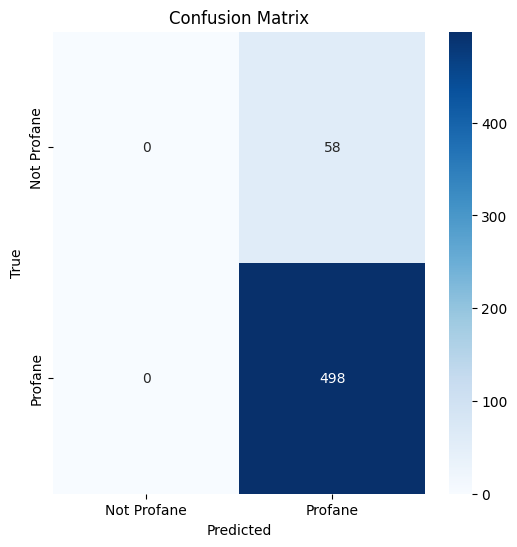

In [9]:
# Step 1: Load dataset from a single CSV file and split
df = pd.read_csv('/content/DATASETS/preprocessed_dataset.csv')  # Adjust this path as needed
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)  # 80% train, 20% temp
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)  # Split temp (10% val, 10% test)

# Convert pandas DataFrames to HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Step 2: Load pre-trained BERT tokenizer and model for sequence classification (2 output classes)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Step 3: Tokenization function for the dataset
def tokenize_function(examples):
    return tokenizer(examples['sentence'], padding='max_length', max_length=128, truncation=True)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch tensors
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Step 4: Define Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    learning_rate=0.00001,  # 1e-5 learning rate
    per_device_train_batch_size=64,  # Set batch size
    per_device_eval_batch_size=64,
    num_train_epochs=3,  # Train for 3 epochs
    weight_decay=0.01,
    logging_dir='./logs',
)

# Step 5: Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

# Save the model
trainer.save_model('./trained_bert')

# Step 6: Evaluate the model on the test dataset
results = trainer.evaluate(eval_dataset=test_dataset)

# Step 7: Profanity evaluation - Load the CSV file with profane words
profane_words_df = pd.read_csv('/content/DATASETS/profanity_list(in).csv')  # Adjust the path to your profane words file
profane_words = set(profane_words_df['profanity_list'].tolist())  # Convert to set for faster lookup

# Function to check if a sentence contains profane words
def contains_profane_words(sentence, profane_words):
    words = sentence.split()
    return any(word in profane_words for word in words)

predictions = trainer.predict(test_dataset)
preds = torch.tensor(predictions.predictions).argmax(dim=-1).numpy()
labels = predictions.label_ids

# Compare against actual labels and profanity from the profane words file
predictions_with_profanity = []
for i, sentence in enumerate(test_df['sentence']): # Changed 'text' to 'sentence'
    profane_in_sentence = contains_profane_words(sentence, profane_words)
    # Assuming 1 is 'profane' and 0 is 'not profane', adjust depending on your dataset labeling
    predicted_label = preds[i]
    predictions_with_profanity.append((predicted_label, int(profane_in_sentence)))

predicted_labels, profane_labels = zip(*predictions_with_profanity)

cm = confusion_matrix(profane_labels, predicted_labels)
report = classification_report(profane_labels, predicted_labels, target_names=['Not Profane', 'Profane'])

print("\nClassification Report:\n", report)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Profane', 'Profane'], yticklabels=['Not Profane', 'Profane'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()